In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import sys
sys.path.insert(0, 'drive/Bitirme Tezi/2016.10b/RNN-LSTM')

In [ ]:
!pip install -q keras

In [ ]:
ls

adc.json  drive/  sample_data/


In [ ]:
cd drive/Bitirme Tezi/2016.10b/RNN-LSTM

/content/drive/Bitirme Tezi/2016.10b/RNN-LSTM


Import the libraries

In [ ]:
import os,random
import numpy as np
import pandas as pd
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle
from keras.callbacks import ModelCheckpoint
import itertools

In [ ]:
#%% load dataset
dataSetLoad= pickle.load(open("RML2016.10b.dat", 'rb'), encoding='latin')
len(dataSetLoad.keys())        #number of keys
dataSetLoad['8PSK', -20]       #elements of this key
dataSetLoad['8PSK', -16].shape #shape of this key






(6000, 2, 128)

In [ ]:
SNRs, modulation_types = map(lambda j: sorted(list(set(map(lambda x: x[j], dataSetLoad.keys())))), [1,0]) #SNRs and modulation types
dataSet   = []
data8PSK  = [] 
dataAMDSB = []
dataAMSSB = []
dataBPSK  = []
dataCPFSK = []
dataGFSK  = []
dataPAM4  = []
dataQAM16 = []
dataQAM64 = []
dataQPSK  = []
dataWBFM  = []
label = []
for mod in modulation_types:
    for snr in SNRs:
        if mod == '8PSK':
            data8PSK.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-DSB':
            dataAMDSB.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-SSB':
            dataAMSSB.append(dataSetLoad[(mod,snr)])
        if mod == 'BPSK':
            dataBPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'CPFSK':
            dataCPFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'GFSK':
            dataGFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'PAM4':
            dataPAM4.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM16':
            dataQAM16.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM64':
            dataQAM64.append(dataSetLoad[(mod,snr)])
        if mod == 'QPSK':
            dataQPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'WBFM':
            dataWBFM.append(dataSetLoad[(mod,snr)])
        
        dataSet.append(dataSetLoad[(mod,snr)])
        for i in range(dataSetLoad[(mod,snr)].shape[0]):  
            label.append((mod,snr))
            
dataSet = np.vstack(dataSet)
print(len(dataSet))

1200000


In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
train_index   = []
np.random.seed(2020)
totalNumberSignals = dataSetLoad['8PSK', 0].shape[0]
n_train = int(totalNumberSignals * 7 / 10)
for i in range(len(dataSetLoad)):
    train_index_ = np.random.choice(range(i*dataSetLoad['8PSK', 0].shape[0],dataSetLoad['8PSK', 0].shape[0] + i*dataSetLoad['8PSK', 0].shape[0]), size=n_train, replace=False)
    train_index.append(train_index_)
    
train_index = np.vstack(train_index)
train_index = train_index.flatten() # converting in to 1d array
random.shuffle(train_index) # suffling

test_index = list(set(range(0,dataSet.shape[0]))-set(train_index))
X_train = dataSet[train_index]
X_train = X_train.reshape(len(X_train),X_train[0].shape[0], X_train[0].shape[1],  )
X_test =  dataSet[test_index]
X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], )

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+ 1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), train_index)))
Y_test = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), test_index)))


In [ ]:
in_shape = list(X_train.shape[1:])
print ("X_train shape", X_train.shape)
print ("X_test shape", X_test.shape)
print ("in shape", in_shape)


X_train shape (840000, 2, 128)
X_test shape (360000, 2, 128)
in shape [2, 128]


In [ ]:
def get_model():
  # %% LSTM Model Tanımlama
  model = Sequential()
  # 1. KATMAN
  model.add(LSTM(256, input_shape=(2,128,)))
  model.add(Dropout(0.3))
  # 2. KATMAN
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.3))
  # 3. KATMAN
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.3))
  # 4. KATMAN
  model.add(Dense(64,activation='relu'))


  # çıkış katmanı
  model.add(Dense(len(modulation_types),activation='softmax' ))
  model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )#optimizasyon ve başarım hesaplama metriklerinin belirlenmesi
  model.summary()
  return model

In [ ]:
model1 = get_model()
model2 = get_model()
model3 = get_model()
model4 = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [ ]:
# %% Eğitim ve ağırlıkların .h5 uzantılı dosya şeklinde kaydedilmesi
# en başarılı ağırlıkları kaydet
batchsize1 = 64
batchsize2 = 128
batchsize3 = 512
batchsize4 = 1024
def train_model(batch_size_, model):
    epochs = 100
    # perform training ...
    #   - call the main training loop in keras for our network+dataset
    filepath = 'modulation_model.h5'
    history = model.fit(X_train,
        Y_train,
        batch_size=batch_size_,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, Y_test),
            callbacks = [
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),

            ])
    model.load_weights(filepath)
    return model, history 



In [ ]:
print('model1 is training')
trained_model1, history1 = train_model(batchsize1, model1)
print('model2 is training')
trained_model2, history2 = train_model(batchsize2, model2)
print('model3 is training')
trained_model3, history3 = train_model(batchsize3, model3)
print('model4 is training')
trained_model4, history4 = train_model(batchsize4, model4)

model1 is training
Epoch 1/100
13125/13125 [==============================] - 60s 3ms/step - loss: 2.0160 - accuracy: 0.2102 - val_loss: 1.8104 - val_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 1.81041, saving model to modulation_model.h5
Epoch 2/100
13125/13125 [==============================] - 42s 3ms/step - loss: 1.8108 - accuracy: 0.2819 - val_loss: 1.6536 - val_accuracy: 0.3256

Epoch 00002: val_loss improved from 1.81041 to 1.65365, saving model to modulation_model.h5
Epoch 3/100
13125/13125 [==============================] - 44s 3ms/step - loss: 1.6950 - accuracy: 0.3128 - val_loss: 1.5594 - val_accuracy: 0.3420

Epoch 00003: val_loss improved from 1.65365 to 1.55940, saving model to modulation_model.h5
Epoch 4/100
13125/13125 [==============================] - 42s 3ms/step - loss: 1.5940 - accuracy: 0.3350 - val_loss: 1.4720 - val_accuracy: 0.3710

Epoch 00004: val_loss improved from 1.55940 to 1.47198, saving model to modulation_model.h5
Epoch 5/100
13125/131

In [ ]:
# Show simple version of performance
train_loss, train_acc  = trained_model1.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 64', train_loss)
print('train_acc- batch size = 64', train_acc)
test_loss, test_acc  = trained_model1.evaluate(X_test, Y_test, verbose = 1)
print('test loss- batch size = 64', test_loss)
print('test accuracy- batch size = 64', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model2.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 128', train_loss)
print('train_acc - batch size = 128', train_acc)
test_loss, test_acc  = trained_model2.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 128', test_loss)
print('test accuracy - batch size = 128', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model3.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 512', train_loss)
print('train_acc - batch size = 512', train_acc)
test_loss, test_acc  = trained_model3.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 512', test_loss)
print('test accuracy - batch size = 512', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model4.evaluate(X_train, Y_train, verbose = 1)
print('train_loss  - batch size = 1024', train_loss)
print('train_acc  - batch size = 1024 ', train_acc)
test_loss, test_acc  = trained_model4.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 1024 ', test_loss)
print('test accuracy  - batch size = 1024 ', test_acc)


26250/26250 [==============================] - 48s 2ms/step - loss: 1.0894 - accuracy: 0.5332
train_loss - batch size = 64 1.0894438028335571
train_acc- batch size = 64 0.5331594944000244
11250/11250 [==============================] - 20s 2ms/step - loss: 1.1149 - accuracy: 0.5226
test loss- batch size = 64 1.1149107217788696
test accuracy- batch size = 64 0.5226194262504578
26250/26250 [==============================] - 48s 2ms/step - loss: 1.0875 - accuracy: 0.5369
train_loss - batch size = 128 1.0874865055084229
train_acc - batch size = 128 0.5369476079940796
11250/11250 [==============================] - 20s 2ms/step - loss: 1.1113 - accuracy: 0.5269
test loss - batch size = 128 1.111327052116394
test accuracy - batch size = 128 0.5269250273704529
26250/26250 [==============================] - 48s 2ms/step - loss: 1.1377 - accuracy: 0.5161
train_loss - batch size = 512 1.1376582384109497
train_acc - batch size = 512 0.5161392688751221
11250/11250 [==============================] - 

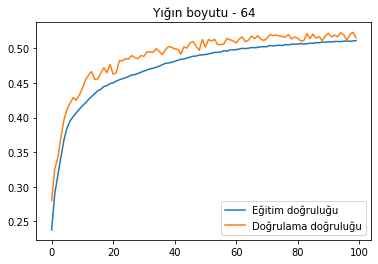

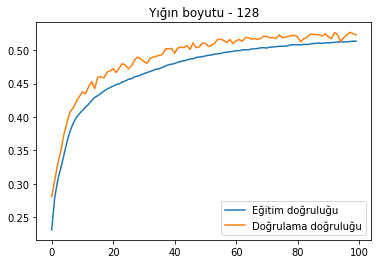

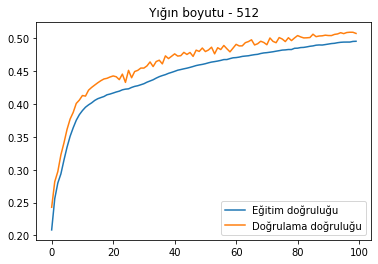

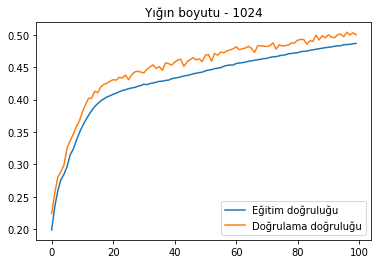

In [ ]:
plt.figure(1)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history1.epoch, history1.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(2)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history2.epoch, history2.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(3)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history3.epoch, history3.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(4)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history4.epoch, history4.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

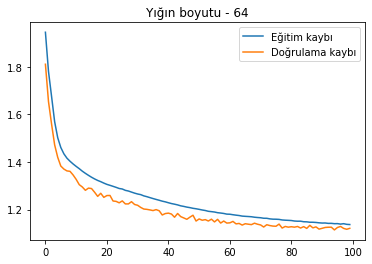

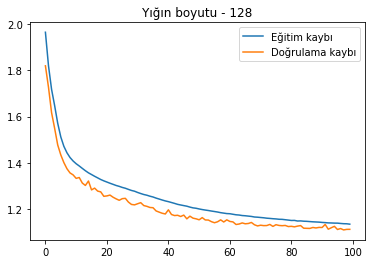

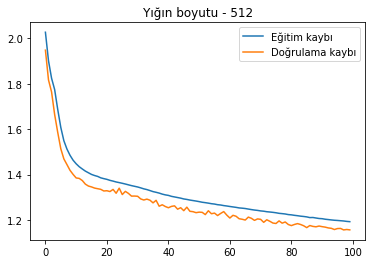

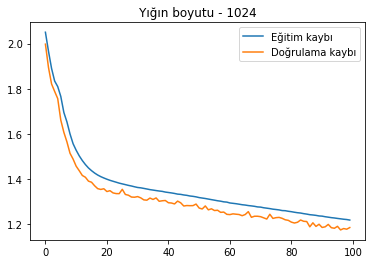

In [ ]:
# Show loss curves 
plt.figure(5)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['loss'], label='Eğitim kaybı')
plt.plot(history1.epoch, history1.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

# Show loss curves 
plt.figure(6)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['loss'], label='Eğitim kaybı')
plt.plot(history2.epoch, history2.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(7)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['loss'], label='Eğitim kaybı')
plt.plot(history3.epoch, history3.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(8)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['loss'], label='Eğitim kaybı')
plt.plot(history4.epoch, history4.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='LSTM', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize = 12)
    plt.yticks(tick_marks, labels, fontsize = 12)
    plt.tight_layout()
    plt.ylabel('Gerçek sınıf', fontsize = 12 )
    plt.xlabel('Tahmin edilen sınıf', fontsize = 12)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                  fontsize=12,
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

In [ ]:
# Plot confusion matrix
def plot_cm_to_batchsize(model, batchsize_):
  test_Y_hat = model.predict(X_test, batch_size=batchsize_)
  conf = np.zeros([len(modulation_types),len(modulation_types)])
  confnorm = np.zeros([len(modulation_types),len(modulation_types)])
  for i in range(0,X_test.shape[0]):
      j = list(Y_test[i,:]).index(1)
      k = int(np.argmax(test_Y_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
  for i in range(0,len(modulation_types)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
  plt.figure(3)
  plot_confusion_matrix(confnorm, labels=modulation_types)  

<Figure size 432x288 with 0 Axes>

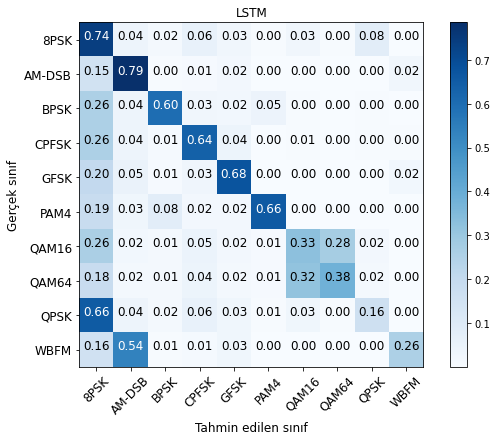

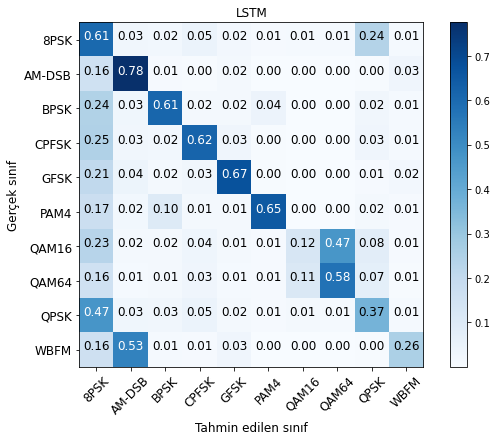

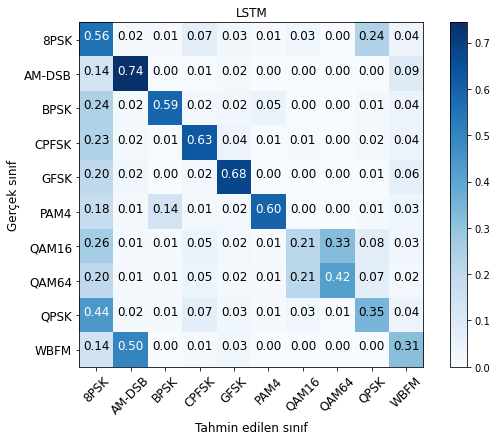

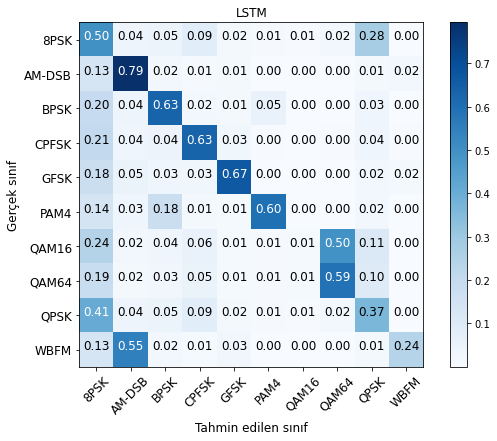

In [ ]:
plot_cm_to_batchsize(trained_model1, batchsize1)
plot_cm_to_batchsize(trained_model2, batchsize2)
plot_cm_to_batchsize(trained_model3, batchsize3)
plot_cm_to_batchsize(trained_model4, batchsize4)

In [ ]:
# Plot confusion matrix
def plot_cm_snr(model, batch_size):
  acc = {}
  for snr in SNRs:
      # extract modulation_types @ SNR
      test_SNRs = list(map(lambda x: label[x][1], test_index))
      test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
      test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

      # estimate modulation_types
      test_Y_i_hat = model.predict(test_X_i)
      conf = np.zeros([len(modulation_types),len(modulation_types)])
      confnorm = np.zeros([len(modulation_types),len(modulation_types)])
      for i in range(0,test_X_i.shape[0]):
          j = list(test_Y_i[i,:]).index(1)
          k = int(np.argmax(test_Y_i_hat[i,:]))
          conf[j,k] = conf[j,k] + 1
      for i in range(0,len(modulation_types)):
          confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
      plt.figure()
      plot_confusion_matrix(confnorm, labels=modulation_types, title="LSTM, SNR=%d dB, Yığın boyutu= %d"%(snr, batch_size))
      
      cor = np.sum(np.diag(conf))
      ncor = np.sum(conf) - cor
      print ("SNR : ", snr)
      print ("Overall Accuracy:", cor / (cor+ncor))
      acc[snr] = 1.0*cor/(cor+ncor)
  
  return acc

    




SNR :  -20
Overall Accuracy: 0.10616666666666667
SNR :  -18
Overall Accuracy: 0.10972222222222222
SNR :  -16
Overall Accuracy: 0.11677777777777777
SNR :  -14
Overall Accuracy: 0.13111111111111112
SNR :  -12
Overall Accuracy: 0.16666666666666666
SNR :  -10
Overall Accuracy: 0.2591111111111111
SNR :  -8
Overall Accuracy: 0.37527777777777777
SNR :  -6
Overall Accuracy: 0.4842222222222222
SNR :  -4
Overall Accuracy: 0.592
SNR :  -2
Overall Accuracy: 0.6677777777777778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


SNR :  0
Overall Accuracy: 0.7187777777777777
SNR :  2
Overall Accuracy: 0.7368888888888889
SNR :  4
Overall Accuracy: 0.7481666666666666
SNR :  6
Overall Accuracy: 0.7470555555555556
SNR :  8
Overall Accuracy: 0.7485555555555555
SNR :  10
Overall Accuracy: 0.7508888888888889
SNR :  12
Overall Accuracy: 0.7466666666666667
SNR :  14
Overall Accuracy: 0.7483333333333333
SNR :  16
Overall Accuracy: 0.7473333333333333
SNR :  18
Overall Accuracy: 0.7508888888888889
SNR :  -20
Overall Accuracy: 0.103
SNR :  -18
Overall Accuracy: 0.11033333333333334
SNR :  -16
Overall Accuracy: 0.11594444444444445
SNR :  -14
Overall Accuracy: 0.13444444444444445
SNR :  -12
Overall Accuracy: 0.18144444444444444
SNR :  -10
Overall Accuracy: 0.26172222222222224
SNR :  -8
Overall Accuracy: 0.3466666666666667
SNR :  -6
Overall Accuracy: 0.4925555555555556
SNR :  -4
Overall Accuracy: 0.6077777777777778
SNR :  -2
Overall Accuracy: 0.6741111111111111
SNR :  0
Overall Accuracy: 0.7253888888888889
SNR :  2
Overall Accu

<Figure size 432x288 with 0 Axes>

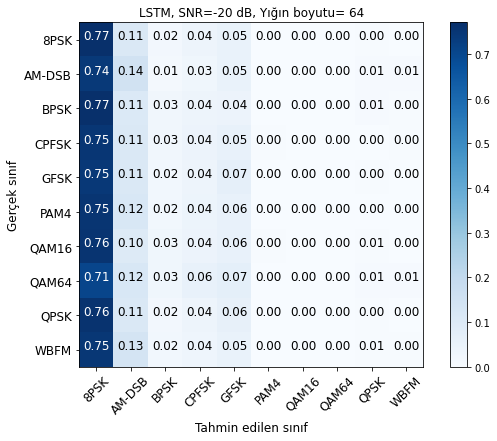

<Figure size 432x288 with 0 Axes>

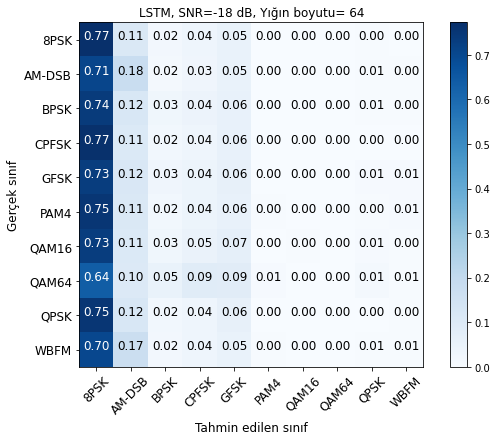

<Figure size 432x288 with 0 Axes>

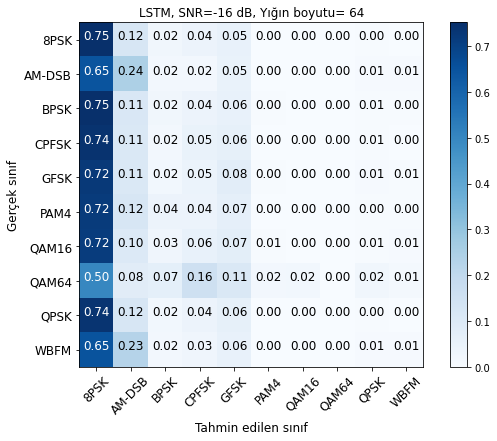

<Figure size 432x288 with 0 Axes>

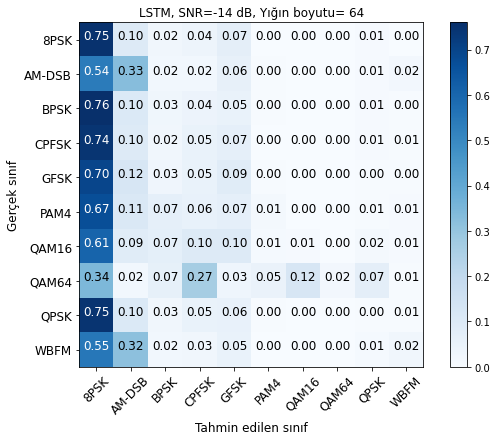

<Figure size 432x288 with 0 Axes>

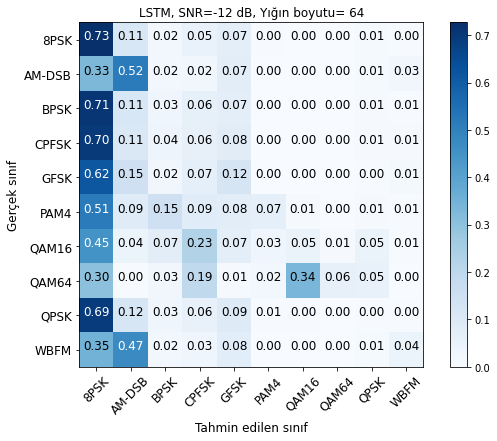

<Figure size 432x288 with 0 Axes>

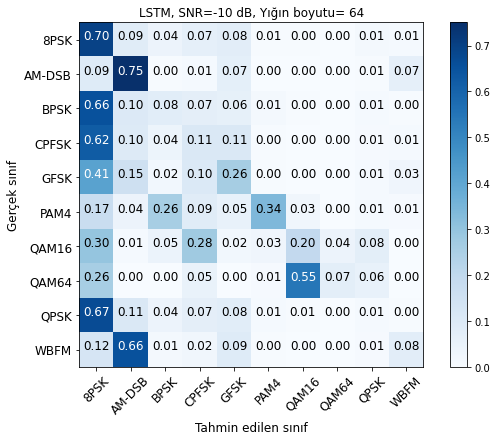

<Figure size 432x288 with 0 Axes>

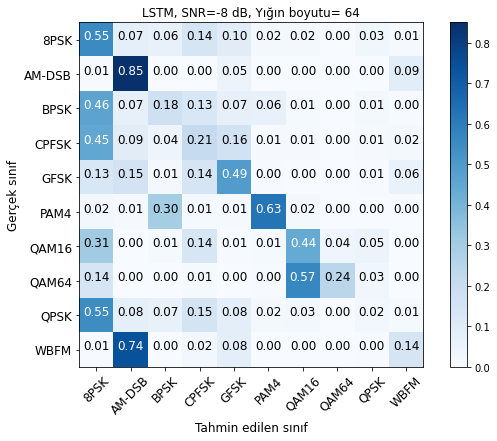

<Figure size 432x288 with 0 Axes>

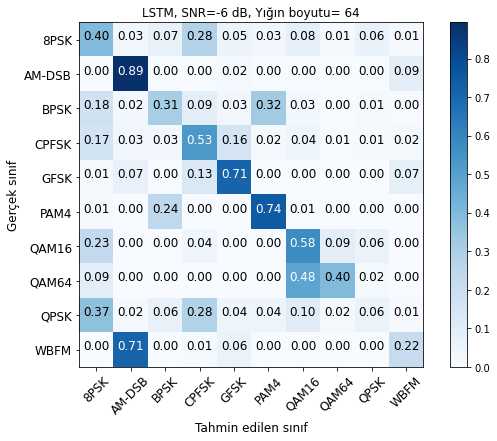

<Figure size 432x288 with 0 Axes>

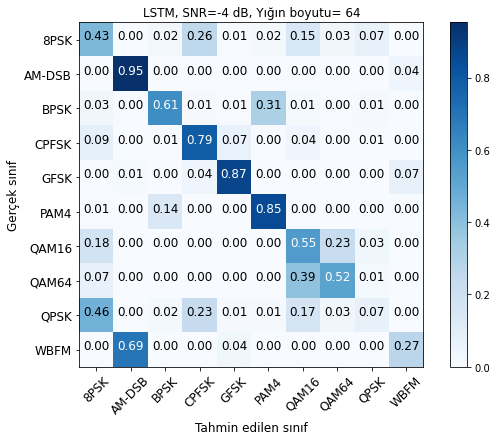

<Figure size 432x288 with 0 Axes>

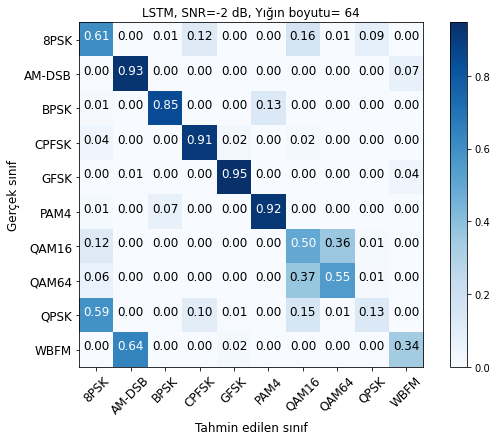

<Figure size 432x288 with 0 Axes>

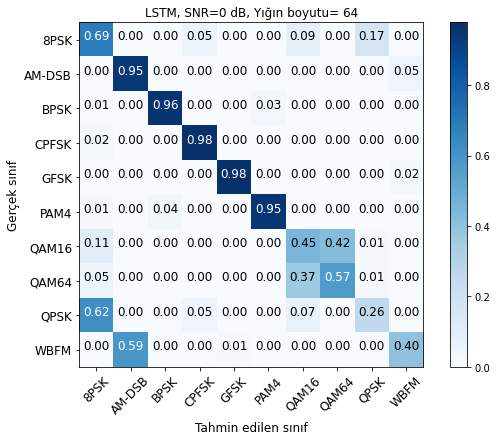

<Figure size 432x288 with 0 Axes>

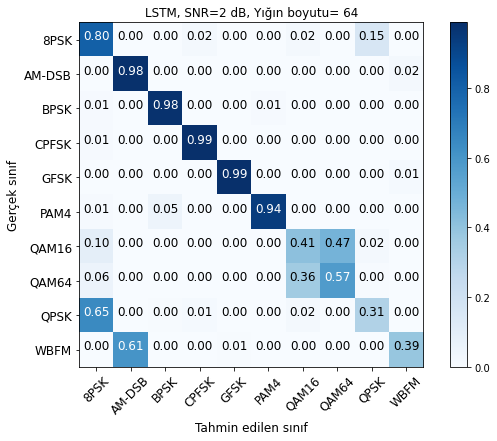

<Figure size 432x288 with 0 Axes>

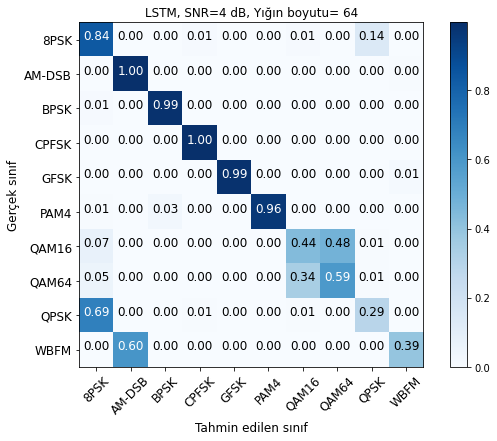

<Figure size 432x288 with 0 Axes>

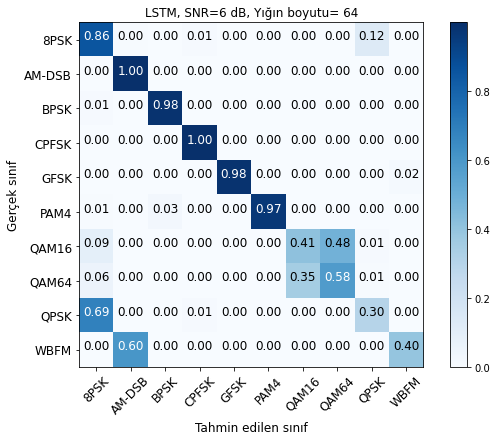

<Figure size 432x288 with 0 Axes>

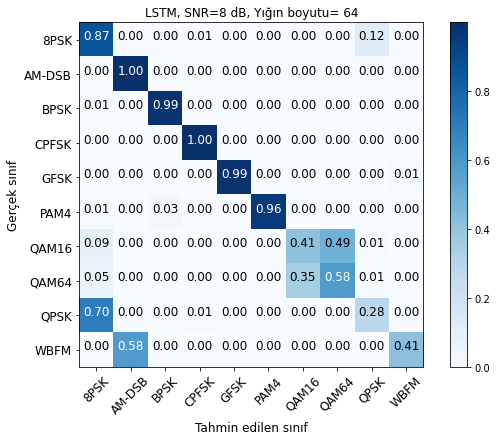

<Figure size 432x288 with 0 Axes>

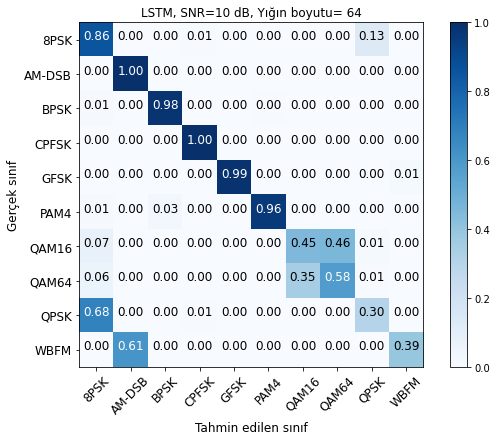

<Figure size 432x288 with 0 Axes>

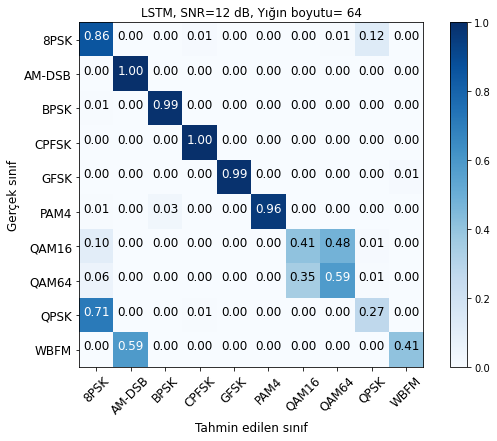

<Figure size 432x288 with 0 Axes>

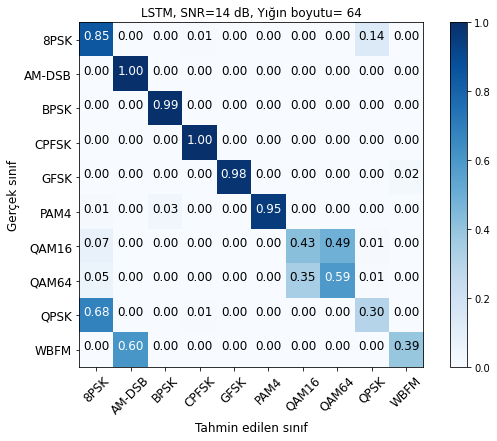

<Figure size 432x288 with 0 Axes>

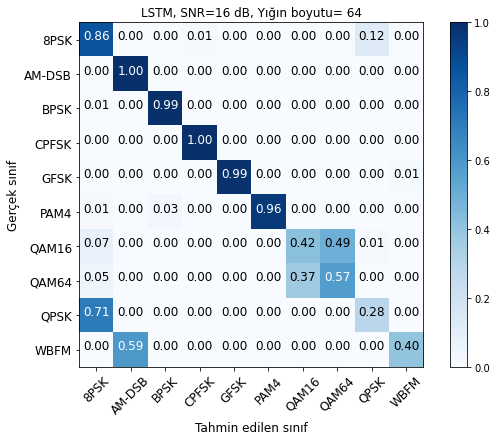

<Figure size 432x288 with 0 Axes>

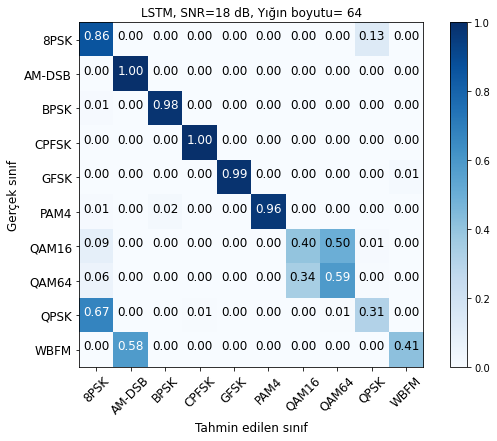

<Figure size 432x288 with 0 Axes>

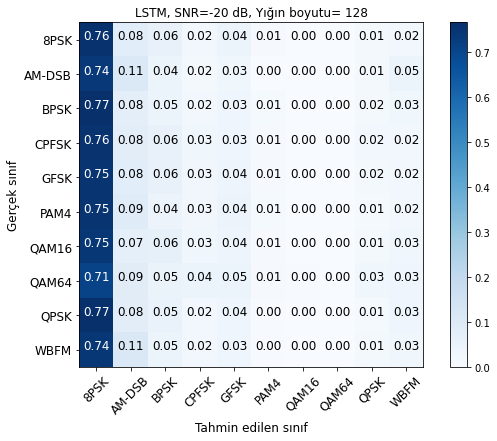

<Figure size 432x288 with 0 Axes>

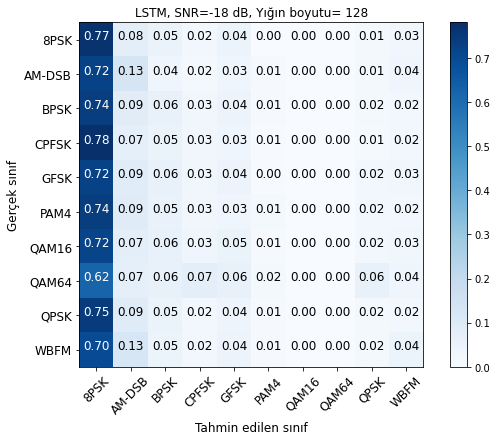

<Figure size 432x288 with 0 Axes>

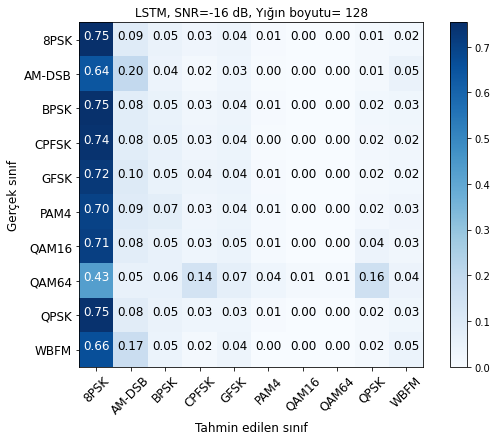

<Figure size 432x288 with 0 Axes>

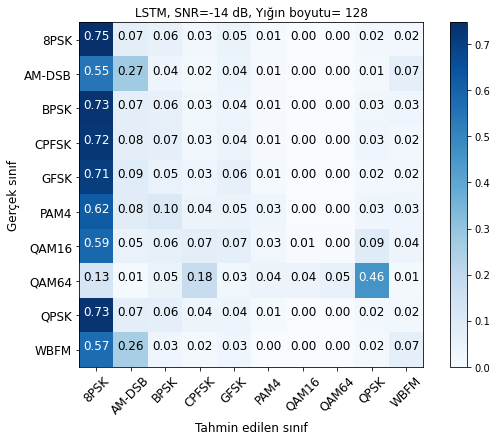

<Figure size 432x288 with 0 Axes>

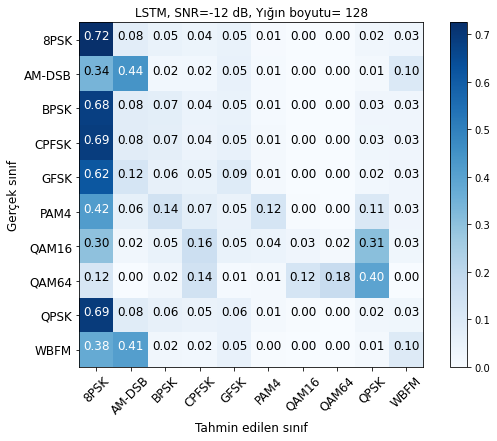

<Figure size 432x288 with 0 Axes>

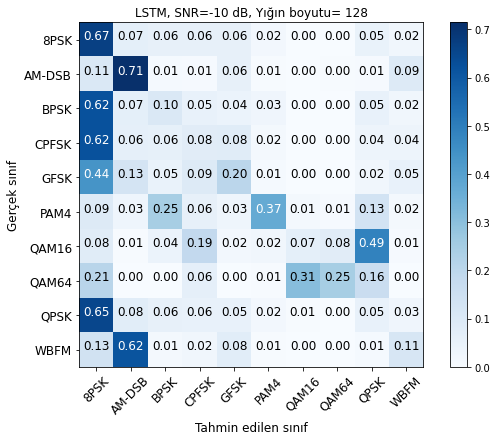

<Figure size 432x288 with 0 Axes>

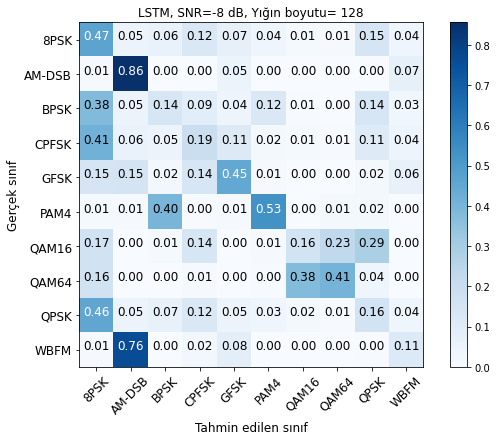

<Figure size 432x288 with 0 Axes>

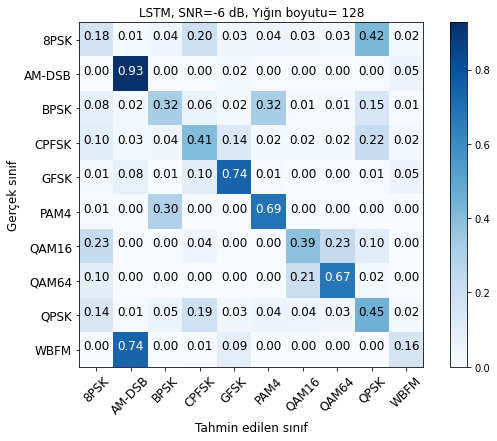

<Figure size 432x288 with 0 Axes>

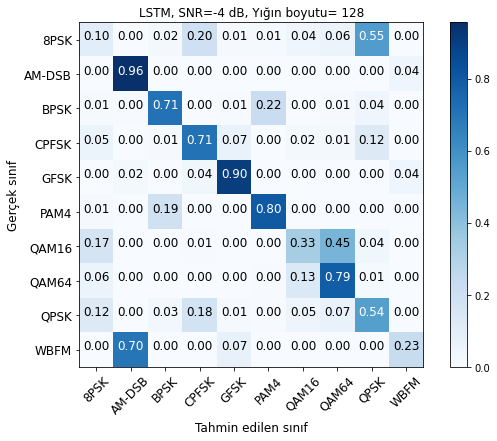

<Figure size 432x288 with 0 Axes>

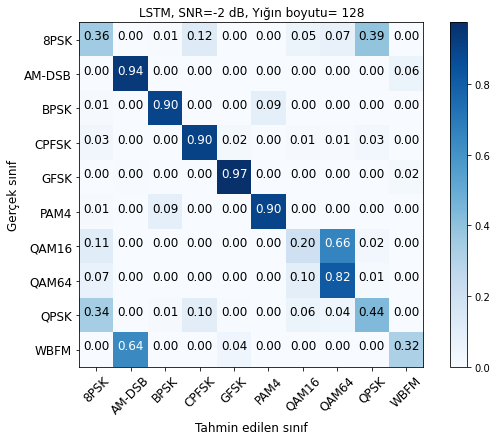

<Figure size 432x288 with 0 Axes>

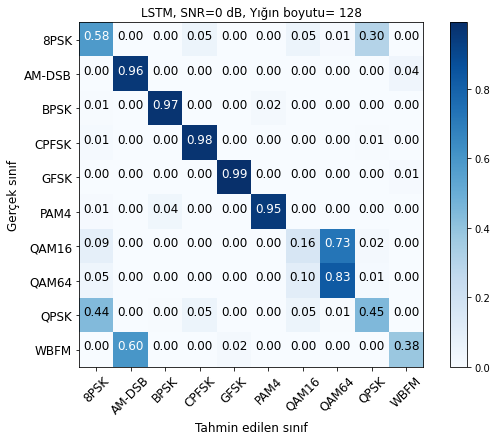

<Figure size 432x288 with 0 Axes>

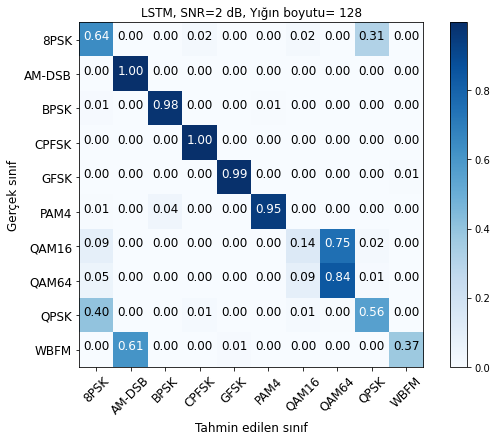

<Figure size 432x288 with 0 Axes>

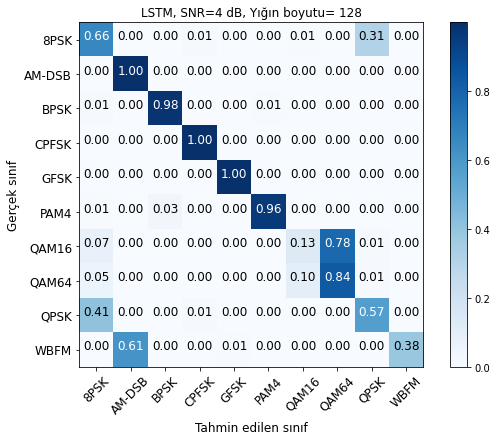

<Figure size 432x288 with 0 Axes>

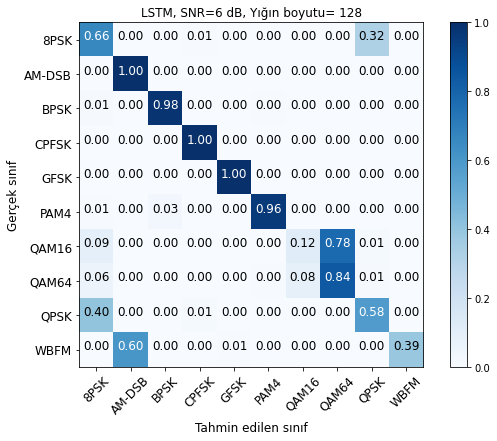

<Figure size 432x288 with 0 Axes>

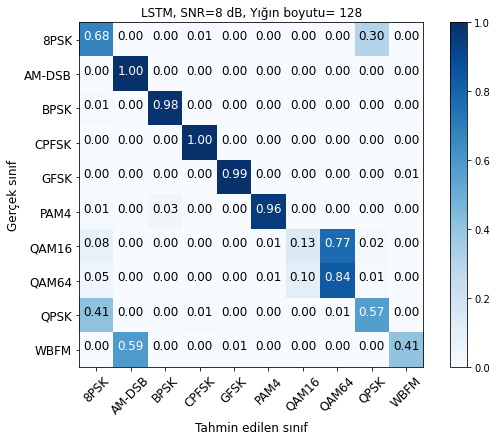

<Figure size 432x288 with 0 Axes>

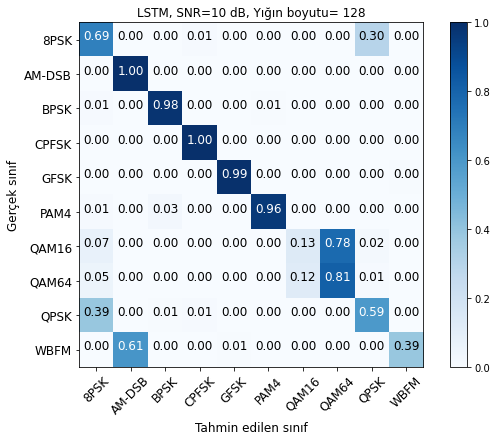

<Figure size 432x288 with 0 Axes>

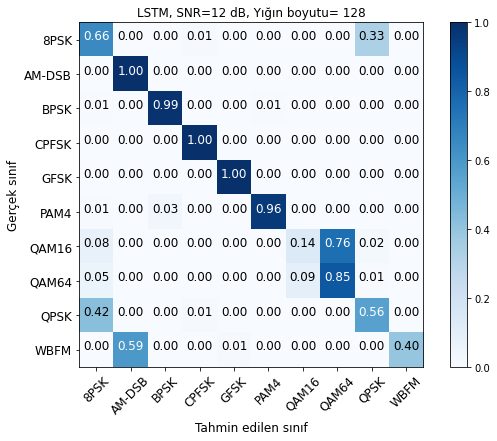

<Figure size 432x288 with 0 Axes>

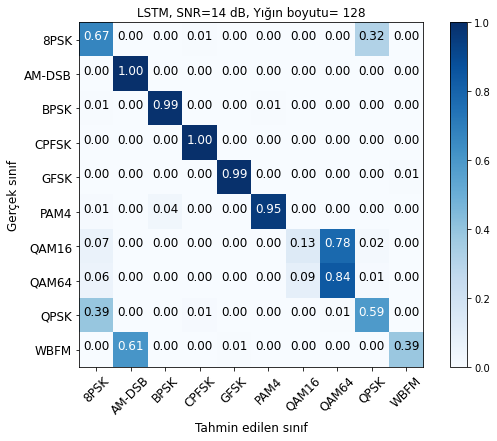

<Figure size 432x288 with 0 Axes>

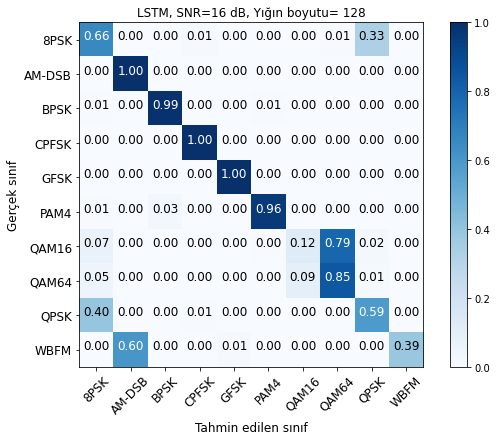

<Figure size 432x288 with 0 Axes>

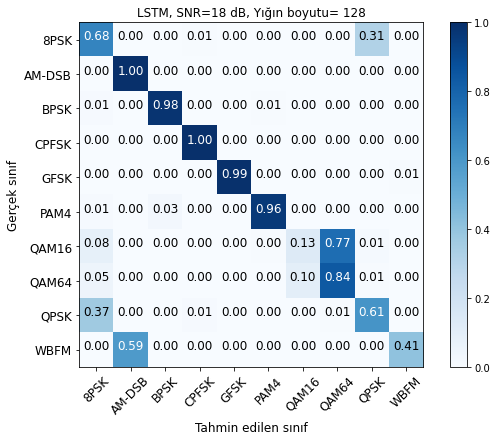

<Figure size 432x288 with 0 Axes>

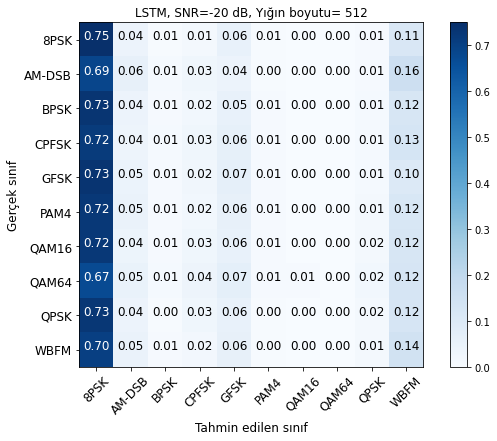

<Figure size 432x288 with 0 Axes>

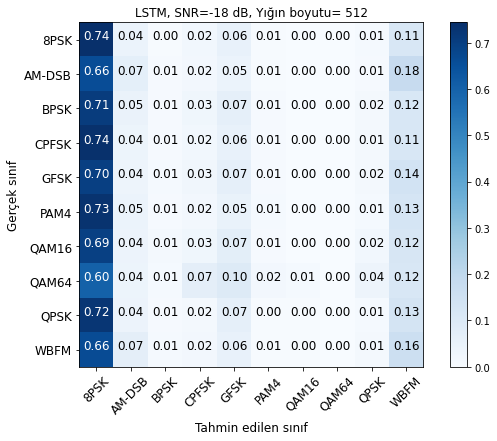

<Figure size 432x288 with 0 Axes>

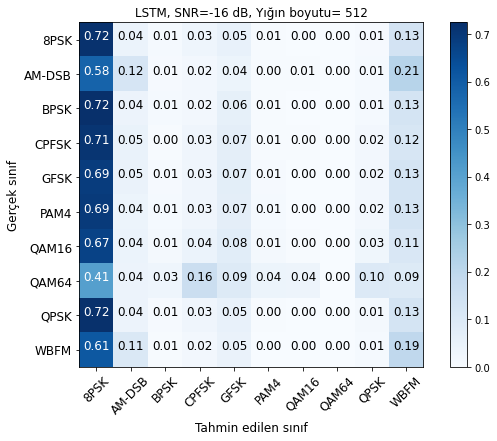

<Figure size 432x288 with 0 Axes>

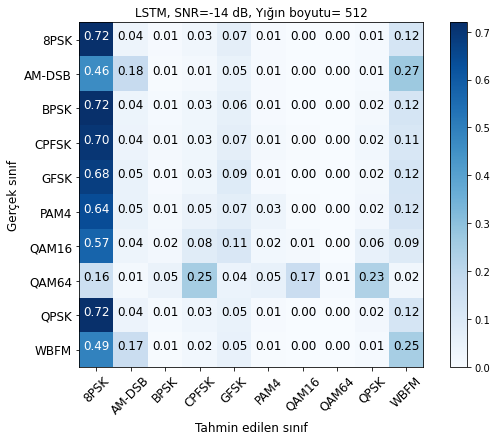

<Figure size 432x288 with 0 Axes>

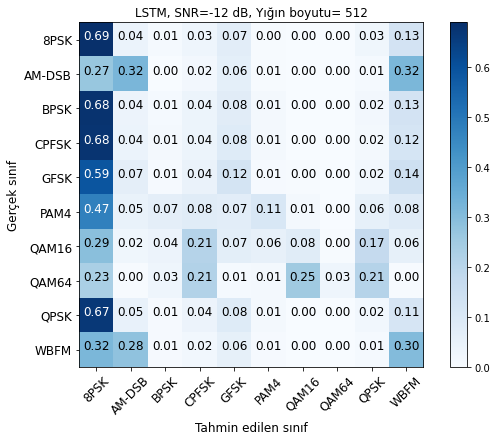

<Figure size 432x288 with 0 Axes>

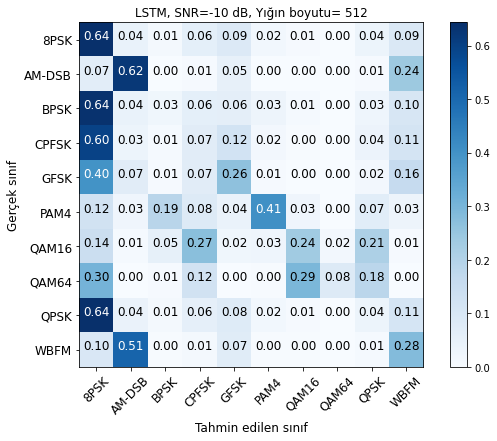

<Figure size 432x288 with 0 Axes>

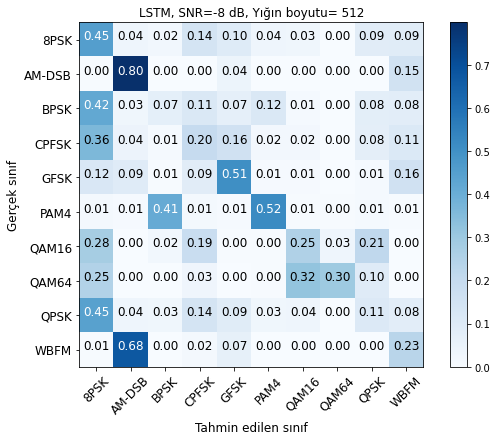

<Figure size 432x288 with 0 Axes>

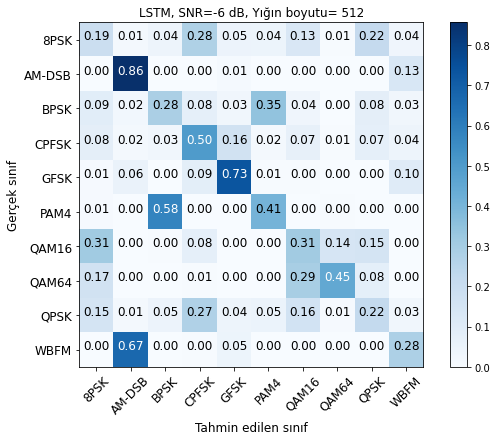

<Figure size 432x288 with 0 Axes>

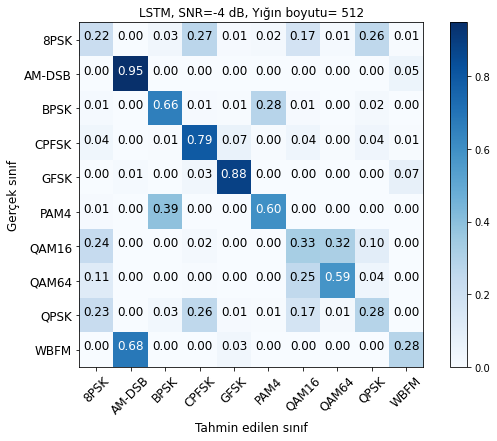

<Figure size 432x288 with 0 Axes>

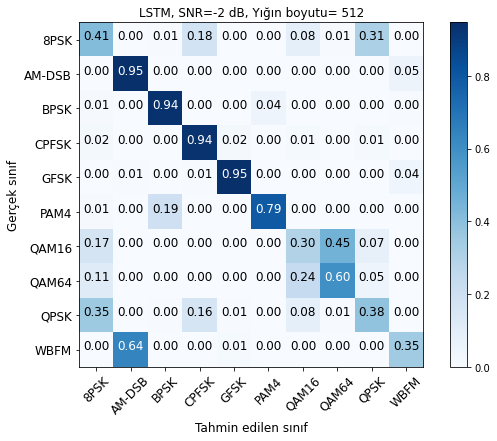

<Figure size 432x288 with 0 Axes>

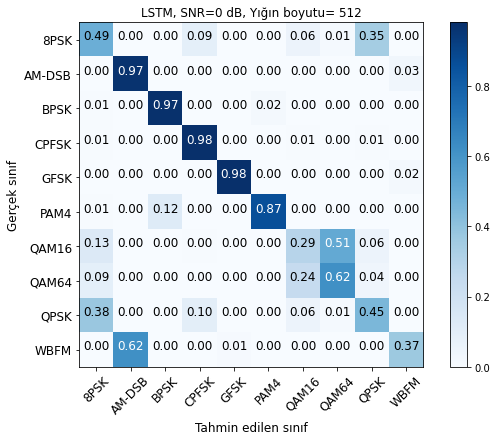

<Figure size 432x288 with 0 Axes>

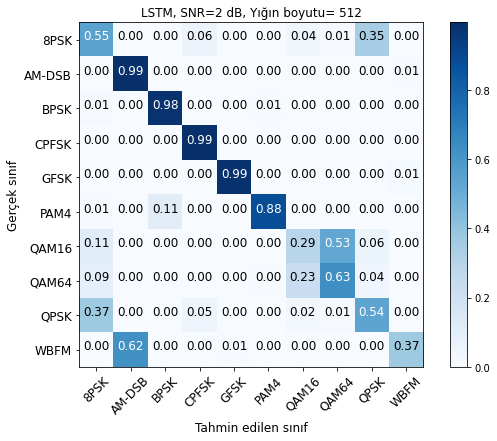

<Figure size 432x288 with 0 Axes>

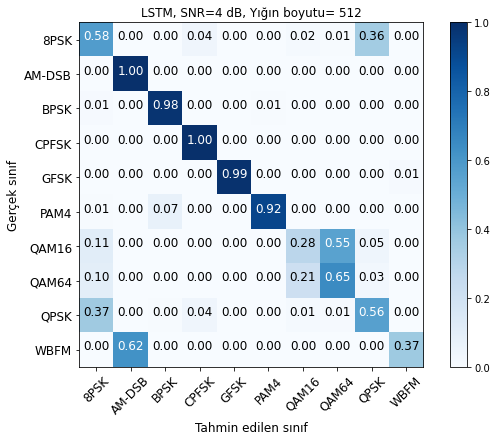

<Figure size 432x288 with 0 Axes>

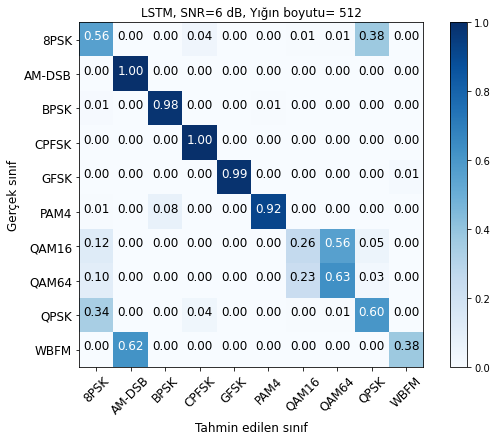

<Figure size 432x288 with 0 Axes>

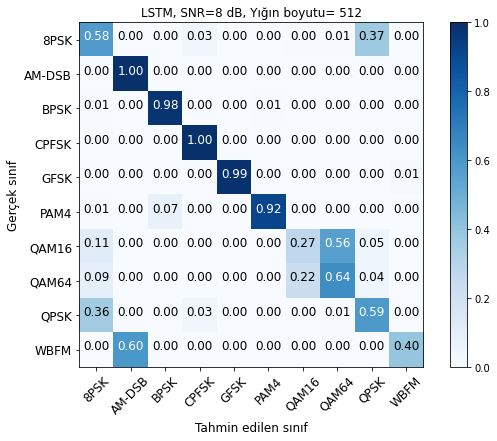

<Figure size 432x288 with 0 Axes>

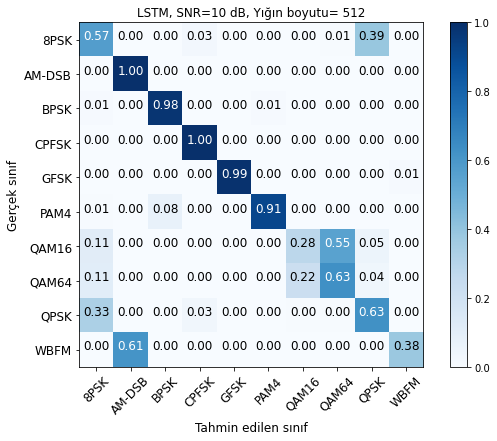

<Figure size 432x288 with 0 Axes>

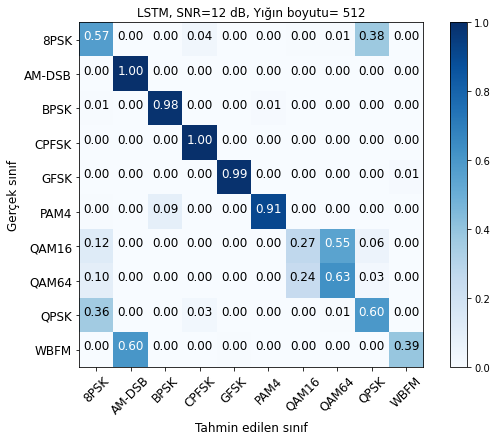

<Figure size 432x288 with 0 Axes>

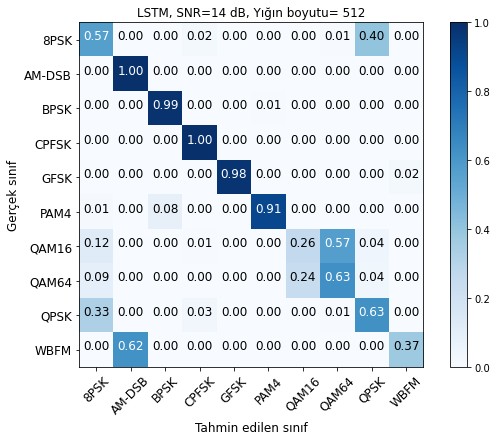

<Figure size 432x288 with 0 Axes>

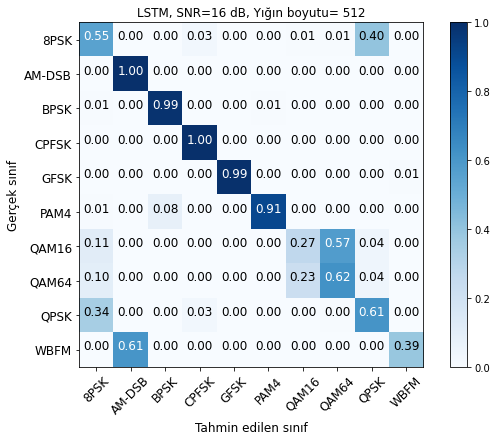

<Figure size 432x288 with 0 Axes>

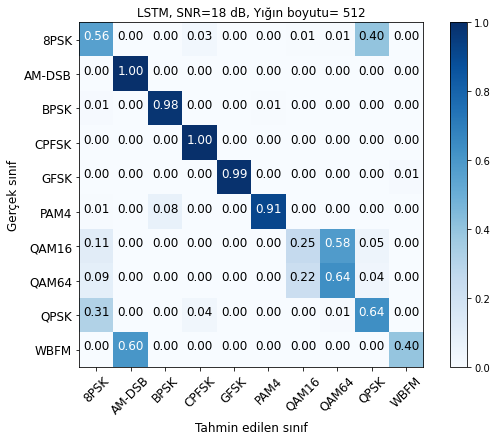

<Figure size 432x288 with 0 Axes>

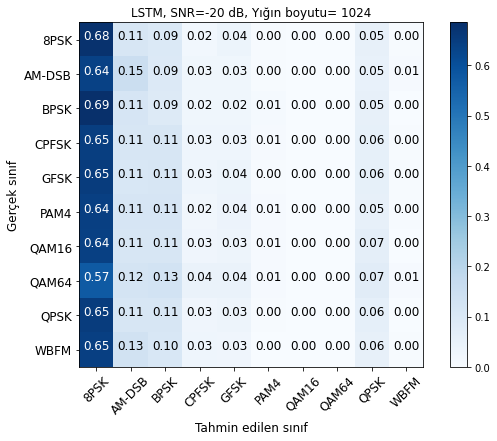

<Figure size 432x288 with 0 Axes>

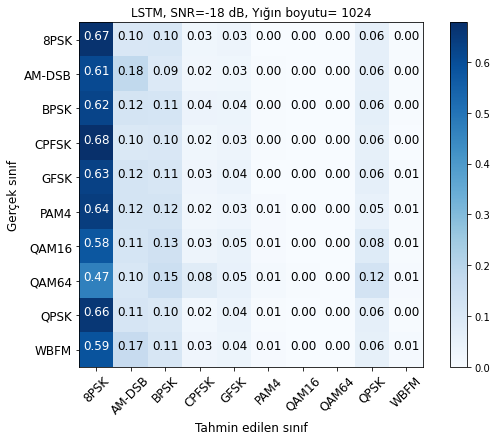

<Figure size 432x288 with 0 Axes>

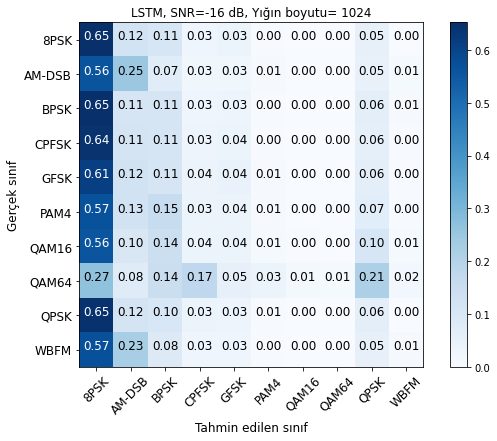

<Figure size 432x288 with 0 Axes>

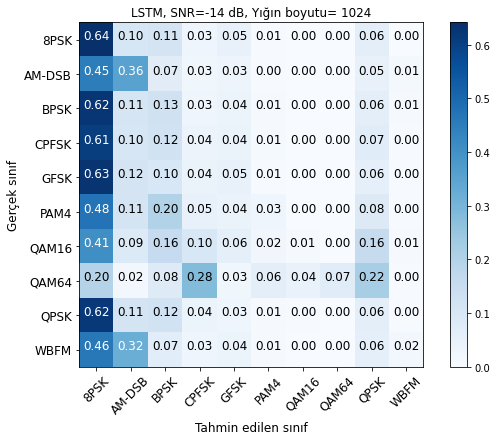

<Figure size 432x288 with 0 Axes>

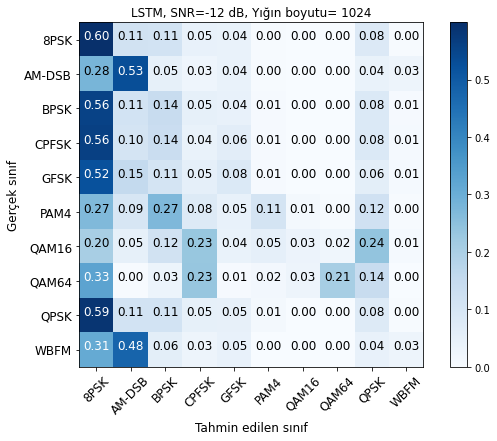

<Figure size 432x288 with 0 Axes>

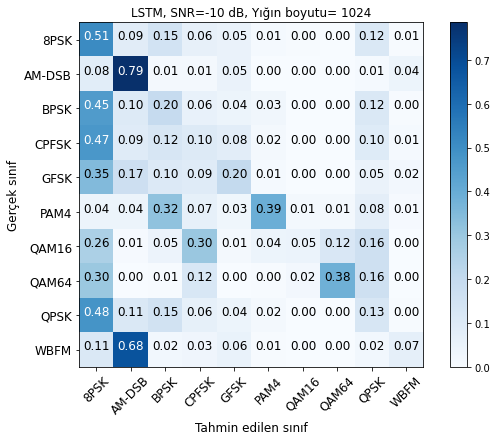

<Figure size 432x288 with 0 Axes>

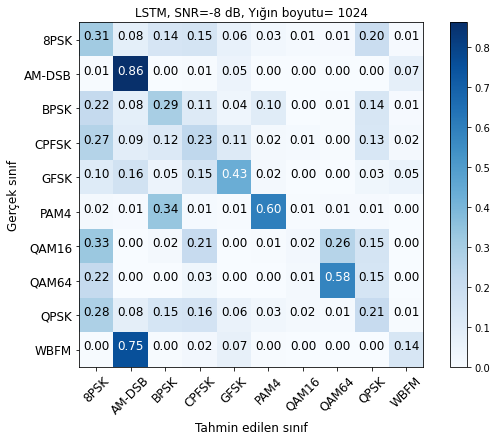

<Figure size 432x288 with 0 Axes>

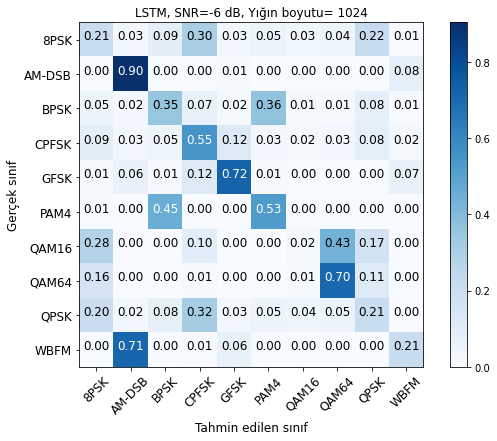

<Figure size 432x288 with 0 Axes>

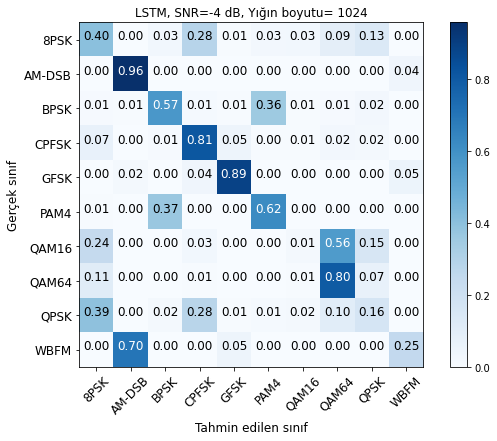

<Figure size 432x288 with 0 Axes>

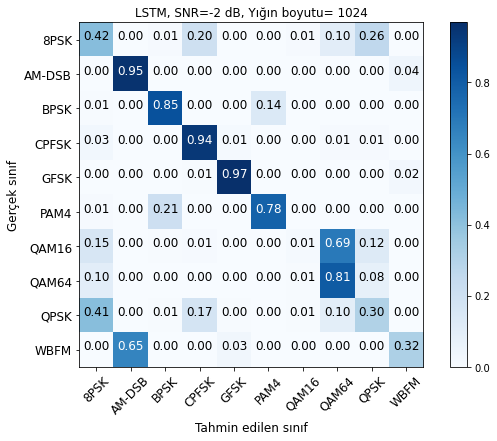

<Figure size 432x288 with 0 Axes>

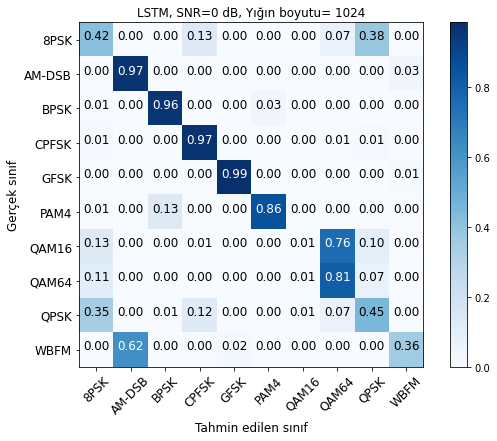

<Figure size 432x288 with 0 Axes>

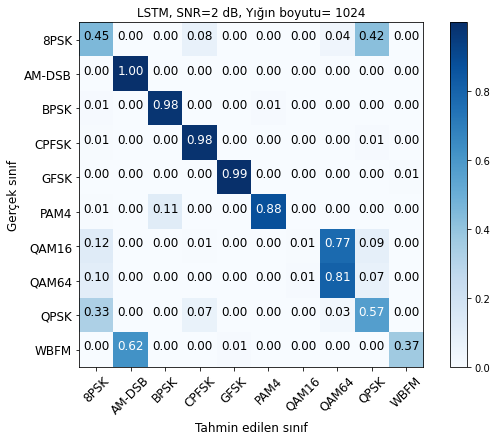

<Figure size 432x288 with 0 Axes>

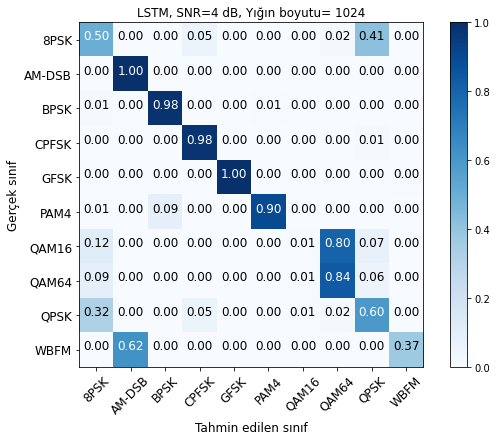

<Figure size 432x288 with 0 Axes>

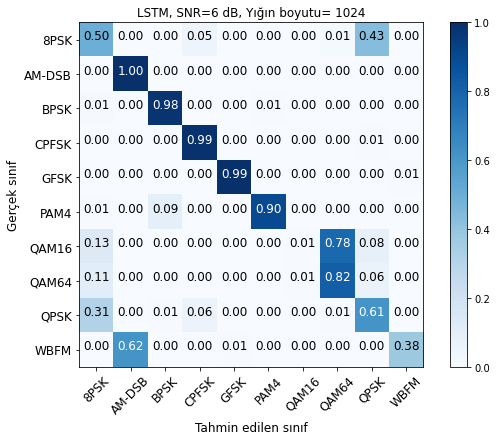

<Figure size 432x288 with 0 Axes>

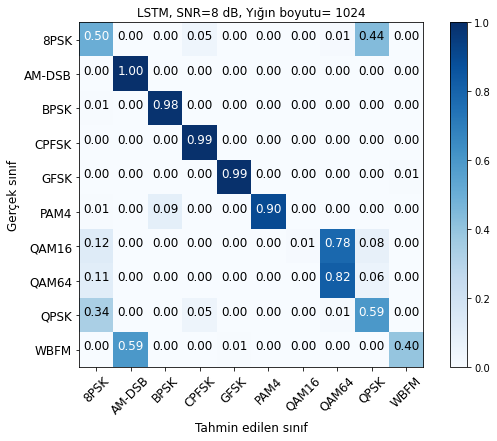

<Figure size 432x288 with 0 Axes>

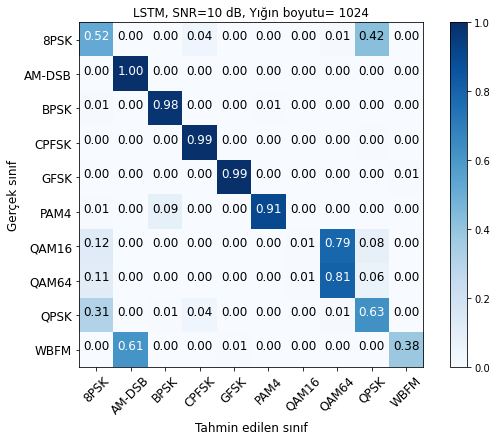

<Figure size 432x288 with 0 Axes>

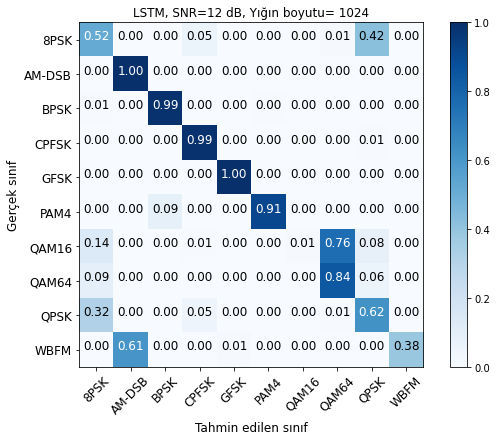

<Figure size 432x288 with 0 Axes>

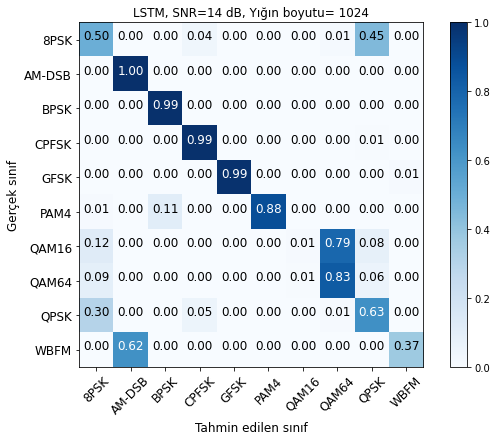

<Figure size 432x288 with 0 Axes>

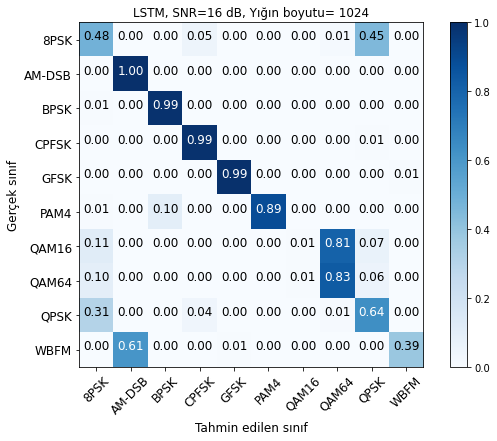

<Figure size 432x288 with 0 Axes>

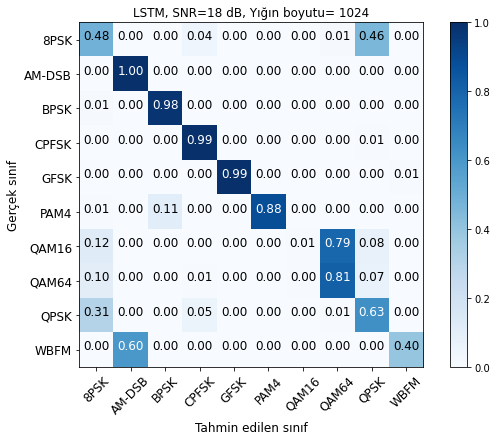

In [ ]:
acc1 = plot_cm_snr(trained_model1, batchsize1)
acc2 = plot_cm_snr(trained_model2, batchsize2) 
acc3 = plot_cm_snr(trained_model3, batchsize3) 
acc4 = plot_cm_snr(trained_model4, batchsize4) 

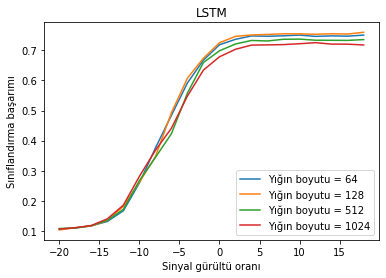

In [ ]:
# Plot accuracy curve
plt.plot(SNRs, list(map(lambda x: acc1[x], SNRs)), label = 'Yığın boyutu = 64')
plt.plot(SNRs, list(map(lambda x: acc2[x], SNRs)), label = 'Yığın boyutu = 128')
plt.plot(SNRs, list(map(lambda x: acc3[x], SNRs)), label = 'Yığın boyutu = 512')
plt.plot(SNRs, list(map(lambda x: acc4[x], SNRs)), label = 'Yığın boyutu = 1024')
plt.title("LSTM")
plt.xlabel("Sinyal gürültü oranı")
plt.ylabel("Sınıflandırma başarımı")
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 64 sonuçları")
y_pred = trained_model1.predict(X_test, batch_size=batchsize1)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 64 sonuçları
roc_auc_score:  0.9187168293424213
mean_absolute_error:  0.10656000907121807
mean_squared_error:  0.052615768203211385
r2_score:  0.41538035329391854


array([0.33711111, 0.64088889, 0.55266667, 0.54138889, 0.60386111,
       0.61947222, 0.01722222, 0.32705556, 0.10891667, 0.23708333])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 128 sonuçları")
y_pred = trained_model2.predict(X_test, batch_size=batchsize2)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 128 sonuçları
roc_auc_score:  0.9191775688743142
mean_absolute_error:  0.1063831668286637
mean_squared_error:  0.052520817323127744
r2_score:  0.4164353630726296


array([2.65666667e-01, 6.48444444e-01, 5.56444444e-01, 5.33666667e-01,
       6.17666667e-01, 6.09166667e-01, 1.11111111e-04, 4.56416667e-01,
       2.32722222e-01, 2.25583333e-01])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 512 sonuçları")
y_pred = trained_model3.predict(X_test, batch_size=batchsize3)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 512 sonuçları
roc_auc_score:  0.9125488431670096
mean_absolute_error:  0.10963445720771361
mean_squared_error:  0.05452967797319508
r2_score:  0.3941146891828745


array([0.08672222, 0.64477778, 0.56122222, 0.55080556, 0.61419444,
       0.55291667, 0.00397222, 0.27130556, 0.13652778, 0.23247222])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 1024 sonuçları")
y_pred = trained_model4.predict(X_test, batch_size=batchsize4)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 1024 sonuçları
roc_auc_score:  0.9096002276748972
mean_absolute_error:  0.11160056810721197
mean_squared_error:  0.05524561876568011
r2_score:  0.38615979148855595


array([1.72222222e-02, 6.54027778e-01, 5.52472222e-01, 5.43750000e-01,
       6.15777778e-01, 5.61722222e-01, 2.77777778e-04, 3.20194444e-01,
       7.20833333e-02, 2.22861111e-01])